In [1]:
from utils.loadData import loadDataWithNews
from lstm.preprocessing import prepareTestSetMultiDimensional, getDatasetsMultiDimensional, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick, evaluateFinal
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExampleMultiDimensional
from lstm.callbacks import es_callback, modelckpt_callback

In [2]:
df = loadDataWithNews()
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,positive,neutral,negative
0,0,2020-12-17,21308.351563,23642.660156,21234.675781,22805.162109,22805.162109,71378606374,2,3,0
1,1,2020-12-18,22806.796875,23238.601563,22399.812500,23137.960938,23137.960938,40387896275,3,2,0
2,2,2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,38487546580,0,1,0
3,3,2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,37844228422,1,2,0
4,4,2020-12-21,23474.455078,24059.982422,22159.367188,22803.082031,22803.082031,45852713981,3,3,0


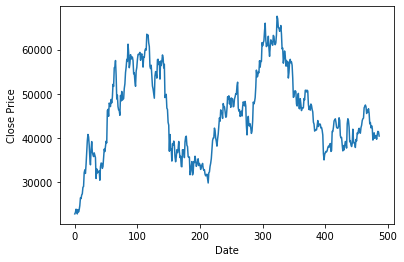

In [3]:
features = df.loc[:, df.columns != 'Date']
features = features.loc[:, features.columns != 'Unnamed: 0']
features = features.loc[:, features.columns != 'Adj Close']
normalized_data, scaler = normalizeAtOnce(features.iloc[:,:-3])
show_data_simple(features["Close"])

2022-04-22 11:30:38.370563: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


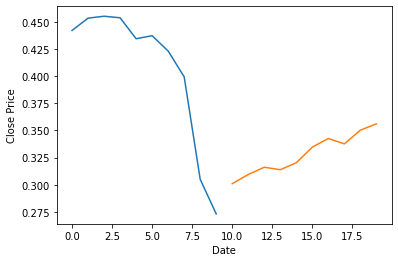

Input shape: (40, 10, 5)
Target shape: (40,)


In [4]:
config = {
    "past": 10,
    "future": 10,
    "neurons": 50,
    "batch_size": 64,
    "epochs": 20,
    "features": normalized_data.shape[1]
}

dataset_train, dataset_val, x_test, y_test = getDatasetsMultiDimensional(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0, :, 3], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [5]:
model = getModel(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 31,910
Trainable params: 31,910
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
5/6 [========================>.....] - ETA: 0s - loss: 0.2750 - rmse: 0.5244 
Epoch 1: val_loss improved from inf to 0.08230, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 4s 182ms/step - loss: 0.2706 - rmse: 0.5202 - val_loss: 0.0823 - val_rmse: 0.2869
Epoch 2/20
5/6 [========================>.....] - ETA: 0s - loss: 0.1458 - rmse: 0.3819
Epoch 2: val_loss improved from 0.08230 to 0.02607, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 0s 31ms/step - loss: 0.1379 - rmse: 0.3713 - val_loss: 0.0261 - val_rmse: 0.1615
Epoch 3/20
5/6 [========================>.....] - ETA: 0s - loss: 0.0465 - rmse: 0.2157
Epoch 3: val_loss did not improve from 0.02607
6/6 [==============================] - 0s 28ms/step - loss: 0.0442 - rmse: 0.2103 - val_loss: 0.0275 - val_rmse: 0.1659
Epoch 4/20
6/6 [==============================] - ETA: 0s - loss: 0.0276 - rmse: 0.1660
Epoch 4: val_loss improved from 0.02607 to 

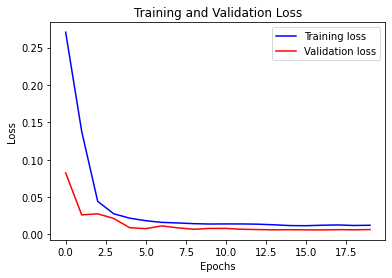

In [6]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [7]:
x, y = prepareTestSetMultiDimensional(x_test, y_test[:,3], config["past"], config["future"])

In [8]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 1s 721ms/step - loss: 0.0079 - rmse: 0.0888
---- TEST RESULTS ----
MSE loss - 0.007877741008996964
RMSE - 0.08875663578510284


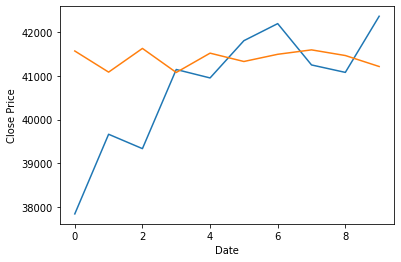

In [9]:
showRegressionExampleMultiDimensional(x[0], y[0], model, scaler)

In [10]:
evaluateFinal(getModel, dataset_train, dataset_val, config, "regression_with_news")

Training Started...
Iterations:
1
2
3
4
5
6
7
8
9
10
Done
